Notebook to summarize IOS Fall 2014 comparisons. Profile comaprisons condensed to a scatter plot.

In [1]:
import os
import glob

import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import datetime

import comparisons

from salishsea_tools import tidetools, viz_tools
from salishsea_tools.nowcast import analyze

from scipy import interpolate as interp
import seaborn as sns

import ACTDR
import pandas as pd
%matplotlib inline

In [2]:
sns.set_color_codes()

In [3]:
nowcast_dir = '/results/SalishSea/nowcast/'
grid_B = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc')    
mesh = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/mesh_mask_SalishSea2.nc')
FIRST_NOWCAST = datetime.datetime(2014, 10,27)

In [4]:
def results_dataset(period, grid, results_dir):
    """Return the results dataset for period (e.g. 1h or 1d)
    and grid (e.g. grid_T, grid_U) from results_dir.
    """
    filename_pattern = 'SalishSea_{period}_*_{grid}.nc'
    filepaths = glob.glob(
        os.path.join(
            results_dir, filename_pattern.format(period=period, grid=grid)))
    return nc.Dataset(filepaths[0])

In [5]:
def get_model_cast(year, month, day, lon, lat, field):
    """Get the model daily mean, max and min corresponding to given year, month, day and lat/lon"""
    
    if field =='Salinity':
        var = 'vosaline'
    elif field == 'Temperature':
        var = 'votemper'
        
    date = datetime.datetime(year, month, day)
    early_days = False
    if date < FIRST_NOWCAST:
        early_days = True
    #Look up grid point
    bathy, X, Y= tidetools.get_bathy_data(grid_B)
    j, i = tidetools.find_closest_model_point(lon, lat, X, Y, bathy)
    # Grab data
    depths = mesh.variables['gdept'][0,:,j,i]
    if early_days:
        var_model = early_model_data(date, j, i, '1h', 'grid_T', var)
    else:
        results_dir = os.path.join(nowcast_dir, date.strftime('%d%b%y').lower())
        grid_T_h = results_dataset('1h', 'grid_T', results_dir)
        var_model = grid_T_h.variables[var][:, :, j, i]
    var_model, tmask = mask_model(j, i, var_model)
    # Daily mean/min/max
    mean_daily = np.mean(var_model, axis=0)
    max_daily = np.max(var_model, axis=0)
    min_daily = np.min(var_model, axis=0)
 
    return mean_daily, max_daily, min_daily, depths, tmask

In [6]:
def mask_model(j, i, var_model):
    """Mask a model variable at a grid point"""
    
    tmask = np.abs(1-mesh.variables['tmask'][:, :, j, i])
    tmask = tmask + np.zeros(var_model.shape)
    var_masked = np.ma.array(var_model, mask=tmask)
    return var_masked, tmask[0,:]

In [7]:
def interpolate_depth(variable, depth_array, depth_new):
    """ interpolates a variable depth profile field to desire depth. 
    Ideally the variable is already masked but this method masked invalid data.
    """
    # mask
    var_mask = np.ma.masked_invalid(variable)
    d_mask = np.ma.masked_invalid(depth_array)
    f = interp.interp1d(d_mask, var_mask, bounds_error=False)
    var_new = f(depth_new)

    return var_new

In [8]:
def prepare_cast_comparison(dep_obs, var_obs, year, month, day, lon, lat, field):
    """Gather model and observed cast data for comparison"""
    
    # model data 
    mean_mod, max_mod, min_mod, dep_mod, tmask = get_model_cast(year, month, day, lon, lat, field)
    
    # interp observations
    interp_obs = interpolate_depth(var_obs, dep_obs, dep_mod)
    interp_obs = np.ma.array(interp_obs, mask=tmask)
    
    return interp_obs, mean_mod, max_mod, min_mod, dep_mod

In [9]:
def get_early_filename(t_orig, period, grid, results_dir):
    

    early_dir = os.path.join(results_dir,'early-days')
    allfiles = glob.glob(os.path.join(early_dir, '*/SalishSea_{}*_{}.nc'.format(period, grid)))

    files = []
    for filename in allfiles:
        base =os.path.basename(filename).split('_')
        if base[2] <= t_orig.strftime('%Y%m%d'):
            if base[3] >= t_orig.strftime('%Y%m%d'):
                files.append(filename)

    files.sort(key=os.path.basename)
    
    return files[0]

In [10]:
def early_model_data(date, j, i, period, grid, var):
    
    sdt=date
    edt = date + datetime.timedelta(days=1)
    
    file = get_early_filename(date, period, grid, nowcast_dir)
    grid = nc.Dataset(file)
    
    times = grid.variables['time_counter']
    dates = nc.num2date(times[:],units=times.units,calendar=times.calendar)
    
    inds = np.where(np.logical_and(dates[:] >=sdt, dates[:]<=edt ))
    var_model =grid.variables[var][inds[0], :, j, i]
    
    return var_model

Testing my functions

In [11]:
ACTDR.load_dat('SOG_2000.dat')

('> open ', 'SOG_2000.dat')
> load CTD_DAT
> load STANDARD_KEYS
('> close ', 'SOG_2000.dat')
> complete


In [12]:
data = pd.DataFrame(ACTDR.CTD_DAT)
data_fall = data[(data.Year>=2014) & (data.Month >=10)  ]

In [13]:
lon_min=-124
lon_max=-123
lat_min=48.7
lat_max=49.3
data_SOG  = comparisons.isolate_region(data_fall,lon_min, lon_max, lat_min, lat_max)

/home/nsoontie/anaconda3/envs/py2/lib/python2.7/site-packages/numpy/ma/core.py:4085: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")


/home/nsoontie/anaconda3/envs/py2/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


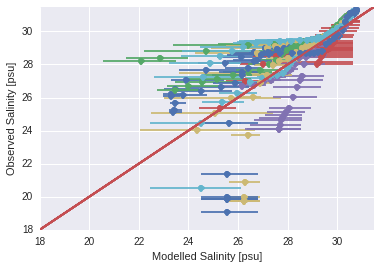

In [14]:
field = 'Salinity'
smin=18
smax=31.5
for dep_obs, var_obs, lon, lat, year, month, day in zip(data_SOG['Depth'],
                                                        data_SOG[field],
                                                        data_SOG['Longitude'],
                                                        data_SOG['Latitude'],
                                                        data_SOG['Year'],
                                                        data_SOG['Month'],
                                                        data_SOG['Day']):

    interp_obs, mean_mod, max_mod, min_mod, dep_mod = prepare_cast_comparison(dep_obs, var_obs,
                                                                              year, month, day,
                                                                              lon, lat, field)
    plt.errorbar(mean_mod, interp_obs, xerr=[mean_mod-min_mod,max_mod-mean_mod ], fmt='o')
    plt.axis([smin, smax, smin, smax])
    plt.plot([smin, smax],[smin, smax], 'r-')
plt.ylabel('Observed Salinity [psu]')
plt.xlabel('Modelled Salinity [psu]')

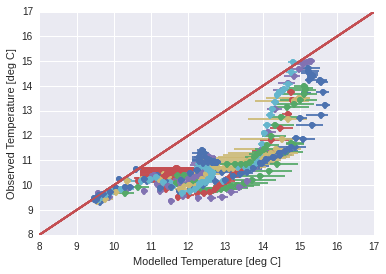

In [15]:
field = 'Temperature'
tmin=8; tmax=17
for dep_obs, var_obs, lon, lat, year, month, day in zip(data_SOG['Depth'],
                                                        data_SOG[field],
                                                        data_SOG['Longitude'],
                                                        data_SOG['Latitude'],
                                                        data_SOG['Year'],
                                                        data_SOG['Month'],
                                                        data_SOG['Day']):

    interp_obs, mean_mod, max_mod, min_mod, dep_mod = prepare_cast_comparison(dep_obs, var_obs,
                                                                              year, month, day,
                                                                              lon, lat, field)
    plt.errorbar(mean_mod, interp_obs, xerr=[mean_mod-min_mod,max_mod-mean_mod ], fmt='o')
    plt.axis([tmin, tmax, tmin, tmax])
    plt.plot([tmin, tmax,],[tmin, tmax,], 'r-')
plt.ylabel('Observed Temperature [deg C]')
plt.xlabel('Modelled Temperature [deg C]')